# **Exploratory Data Anlysis**

To get everything to run as expected make sure the "cox-violent-parsed_filt.csv" data file is saved in the "Content" folder of this notebook.

The EDA is done on the raw, unprocessed dataset provided by COMPAS.

### **Import Modules**

In [2]:
%pip install dask[dataframe] -q
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler, LabelEncoder,MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,accuracy_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.datasets import make_regression,make_classification

def logistic_function(x):
    return 1/1+np.exp(x-0.5)

Note: you may need to restart the kernel to use updated packages.


### **Read data file, identify target feature, & remove it from training data**

We need to remove the target feature's values form the training dataset so we don't train the model with the answers.

We also need to remove the other features that we don't want to consider when predicting the target feature's value.

In this case, it would be all the features that are describing the acts of recidivism some people commited, because this will tell the model exactly who did commit recidivism and wouldn't actually teach the model how to predict a person's likelyhood of recidivism before they do it.

In [3]:
df = pd.read_csv('datasets/cox-violent-parsed_filt.csv')

target = df['event'] # This is the variable we are trying to predict (target feature)


#drop unessasary person info
features = df.drop('id',axis = 1)
features = df.drop('name',axis = 1)
features = df.drop('first',axis = 1)
features = df.drop('last',axis = 1)

### **Find the dimesions & headers of the dataset**

This just gives us a better idea of what datatypes are in our dataset.

In [4]:
print(f'The dimension of the dataset is : {df.shape}')
features.count()  #print the feature headers

The dimension of the dataset is : (18316, 40)


id                         11001
name                       18316
first                      18316
sex                        18316
dob                        18316
age                        18316
age_cat                    18316
race                       18316
juv_fel_count              18316
decile_score               18316
juv_misd_count             18316
juv_other_count            18316
priors_count               18316
days_b_screening_arrest    17019
c_jail_in                  17019
c_jail_out                 17019
c_days_from_compas         17449
c_charge_degree            17449
c_charge_desc              17435
is_recid                   18316
r_charge_degree             8417
r_days_from_arrest          6359
r_offense_date              8417
r_charge_desc               8277
r_jail_in                   6359
violent_recid                  0
is_violent_recid           18316
vr_charge_degree            1339
vr_offense_date             1339
vr_charge_desc              1339
type_of_as

### **Print out non-numerical features**

This helps us know which features are categorical and will need it's data encoded (made numerical) before we can use it in diffrent machine leanring models.

This is a part of preprocessing our data.

In [5]:
# Print out the non-numerical features
features.select_dtypes(exclude = 'number').head()

,name,first,sex,dob,age_cat,race,c_jail_in,c_jail_out,c_charge_degree,c_charge_desc,...,r_charge_desc,r_jail_in,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,score_text,screening_date,v_type_of_assessment,v_score_text
0,miguel hernandez,miguel,Male,18/04/1947,Greater than 45,Other,13/08/2013 6:03,14/08/2013 5:41,(F3),Aggravated Assault w/Firearm,...,NaN,NaN,NaN,NaN,NaN,Risk of Recidivism,Low,14/08/2013,Risk of Violence,Low
1,miguel hernandez,miguel,Male,18/04/1947,Greater than 45,Other,13/08/2013 6:03,14/08/2013 5:41,(F3),Aggravated Assault w/Firearm,...,NaN,NaN,NaN,NaN,NaN,Risk of Recidivism,Low,14/08/2013,Risk of Violence,Low
2,michael ryan,michael,Male,06/02/1985,25 - 45,Caucasian,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Risk of Recidivism,Medium,31/12/2014,Risk of Violence,Low
3,kevon dixon,kevon,Male,22/01/1982,25 - 45,African-American,26/01/2013 3:45,05/02/2013 5:36,(F3),Felony Battery w/Prior Convict,...,Felony Battery (Dom Strang),NaN,(F3),05/07/2013,Felony Battery (Dom Strang),Risk of Recidivism,Low,27/01/2013,Risk of Violence,Low
4,ed philo,ed,Male,14/05/1991,Less than 25,African-American,13/04/2013 4:58,14/04/2013 7:02,(F3),Possession of Cocaine,...,Driving Under The Influence,16/06/2013,NaN,NaN,NaN,Risk of Recidivism,Low,14/04/2013,Risk of Violence,Low


### **Describe the Categorical Features**

this tells us the
  - **count** of values
  - number of **unique** values (diffrent options like small, medium, large [3 unique values])
  - **top** (most common) values
  - **frequency** the top value appears in the dataset
  
This info is given for each non-numerical feature.

In [6]:
features.describe(exclude="number")

,name,first,sex,dob,age_cat,race,c_jail_in,c_jail_out,c_charge_degree,c_charge_desc,...,r_charge_desc,r_jail_in,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,score_text,screening_date,v_type_of_assessment,v_score_text
count,18316,18316,18316,18316,18316,18316,17019,17019,17449,17435,...,8277,6359,1339,1339,1339,18316,18293,18316,18316,18310
unique,10855,3876,2,7485,3,6,9806,8714,14,513,...,341,972,9,570,83,1,3,703,1,3
top,brandon ross,michael,Male,21/11/1991,25 - 45,African-American,04/02/2013 7:24,30/04/2013 7:29,(F3),arrest case no charge,...,Possess Cannabis/20 Grams Or Less,29/04/2014,(M1),06/01/2015,Battery,Risk of Recidivism,Low,20/03/2013,Risk of Violence,Low
freq,13,421,14933,21,10372,9791,13,19,10294,3085,...,635,29,550,14,529,18316,8597,72,18316,11147


### **Describe the numerical data**

We drop the **id** feature here, because it is not relevant to the data.

In [7]:
#drop id feature, it's not relevent
features.drop('id',axis=1).select_dtypes(include='number').describe()

,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,is_recid,r_days_from_arrest,violent_recid,is_violent_recid,decile_score.1,v_decile_score,priors_count.1,event
count,18316.000000,18316.000000,18316.000000,18316.000000,18316.000000,18316.000000,17019.000000,17449.000000,18316.000000,6359.000000,0.0,18316.000000,18316.000000,18316.000000,18316.000000,18316.000000
mean,34.019273,0.076873,4.997052,0.098439,0.124263,3.913191,4.302485,57.694596,0.414774,19.961629,NaN,0.073105,4.997052,4.022822,3.913191,0.044715
std,11.667811,0.464272,2.937569,0.517639,0.524537,5.299864,81.159881,317.994694,0.576449,74.139695,NaN,0.260317,2.937569,2.614189,5.299864,0.206683
min,18.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-597.000000,0.000000,-1.000000,-1.000000,NaN,0.000000,-1.000000,-1.000000,0.000000,0.000000
25%,25.000000,0.000000,2.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,2.000000,2.000000,0.000000,0.000000
50%,31.000000,0.000000,5.000000,0.000000,0.000000,2.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,5.000000,4.000000,2.000000,0.000000
75%,41.000000,0.000000,8.000000,0.000000,0.000000,5.000000,0.000000,2.000000,1.000000,1.000000,NaN,0.000000,8.000000,6.000000,5.000000,0.000000
max,96.000000,20.000000,10.000000,13.000000,17.000000,43.000000,1057.000000,9485.000000,1.000000,993.000000,NaN,1.000000,10.000000,10.000000,43.000000,1.000000


### **Visualize the missing data**

The heat map map will show us where there is missing data, so we can see if it is logical that the data is missing or if there should be data at those points.

**White [True] = missing data [1]**

**dark blue/navy [False] = has data [0]**

Ex.
- **Age** should not be missing any data.

- **r_days_from_arrest** can be missing data, because if a person did not commit recidivism then they should not have any data for this feature, as it does not apply to them. However if they did commit recidivism, then they should have data in this feature.

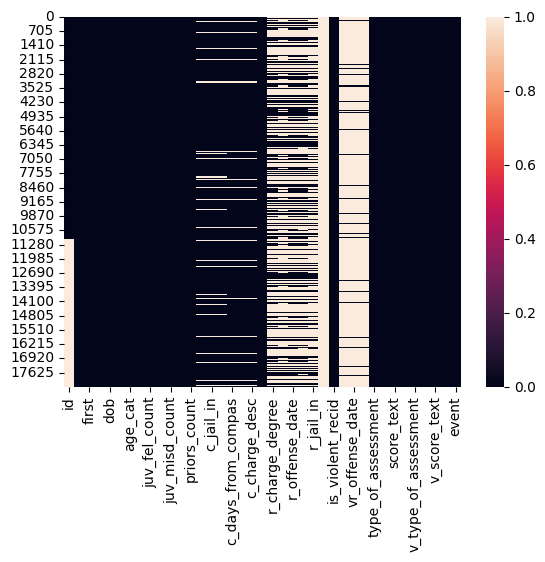

In [8]:
cmap = sns.mpl_palette("Set2", 2)
sns.heatmap(features.isna(),cbar = True) #determine if data is missing & plot results
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)

legend_handles = [Patch(color=cmap[True], label='NAN'),  # red
                  Patch(color=cmap[False], label='Not NAN')]

### **Create Histogram & Frequency Plots**

Create Historgram or Frequency plots for all features to see:  

*   how the values are **distributed**
*   see **patterns** or identify **issues** in a feature's data (missing data, skew, outliers)
*   determine how/where the data needs **preprocess** before picking & training the model



---



**Histogram = Numerical features**

Make Histogram Plots for numerical features



---




**Frequency = Categorical features**

Make Frequency Plots for Categorical (non-numerical) features


---



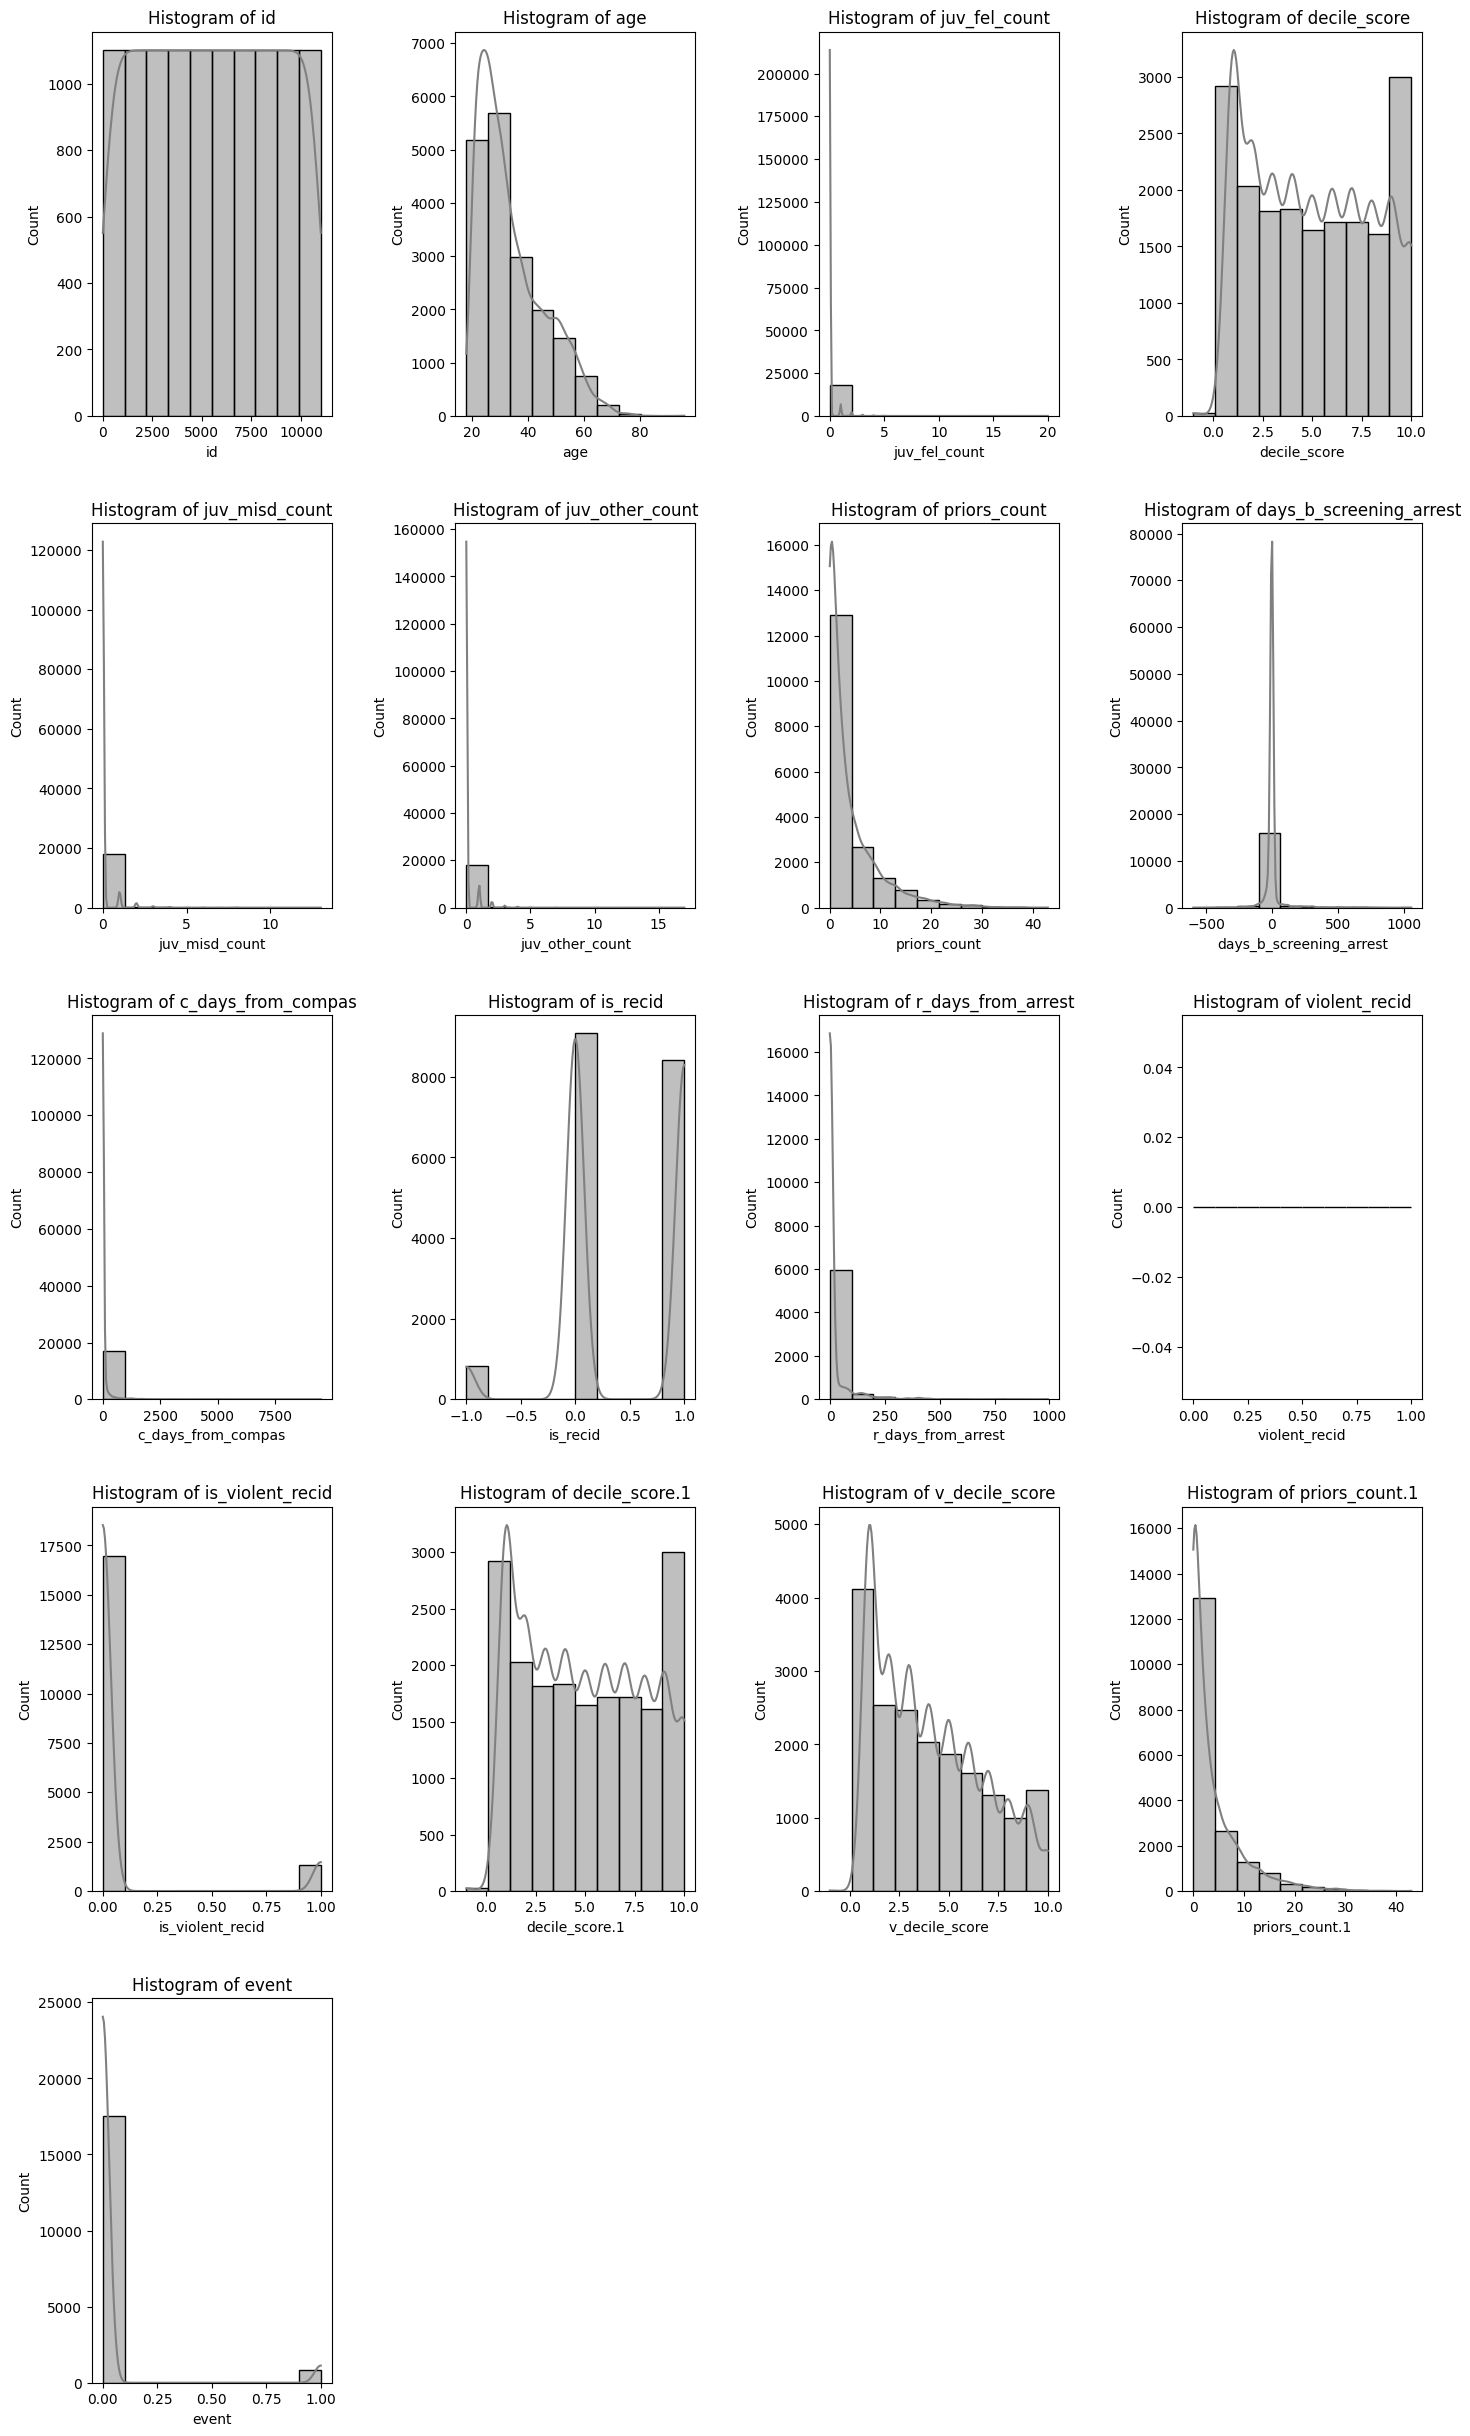

In [9]:
'''
Pulls out all numerical features from the dataset
and creats a histogram plot for that feature.

(only a formatting impact)
Then prints out all plots in a dynamic plotting space,
determined byt he number of features being plotted.
'''
# Select numerical features
numerical_features = df.select_dtypes(include='number').columns

# Calculate the number of rows and columns needed based on the number of features
num_features = len(numerical_features)
num_cols = 4  # columns to organize feature plots
num_rows = int(np.ceil(num_features / num_cols))  # Calculate number of rows needed for all feature plots

# Set up the plotting space
plt.figure(figsize=(15, num_rows * 5))

# Loop through numerical features and plot histograms
for i, feature in enumerate(numerical_features):
    plt.subplot(num_rows, num_cols, i + 1)  # Dynamic number of rows and columns
    sns.histplot(df[feature], kde=True, bins=10, color='grey', edgecolor='black')
    plt.title(f'Histogram of {feature}')
    plt.tight_layout(pad=3.0)

plt.show()

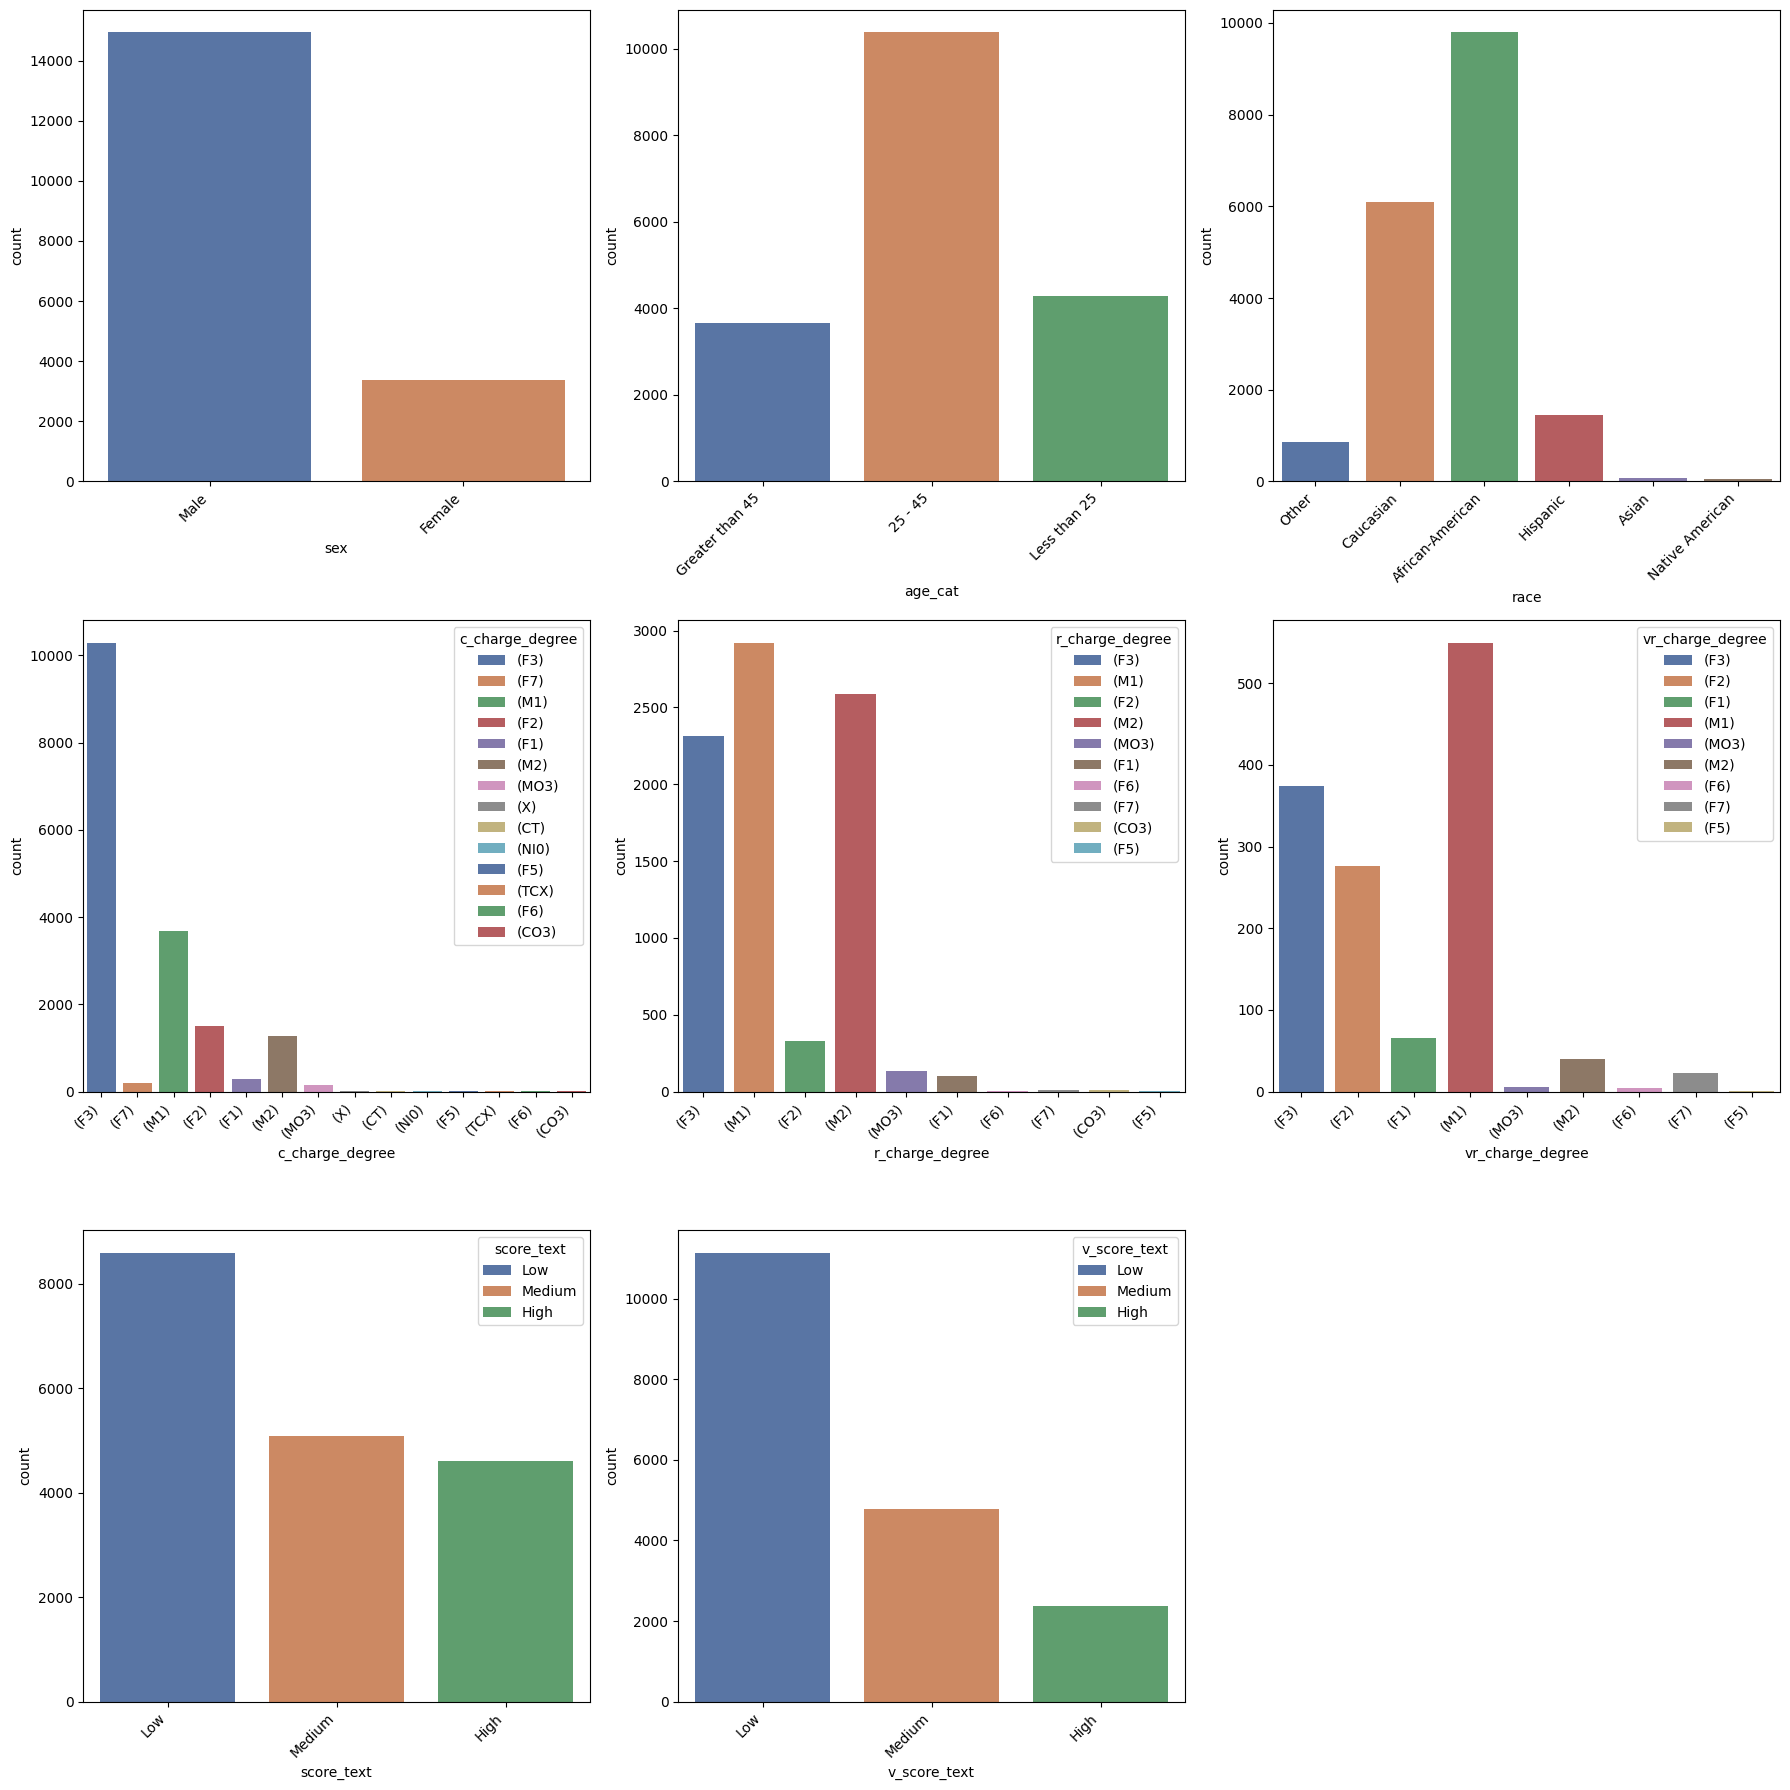

In [10]:
#List of categorical features to plot
plot_vars = ['sex', 'age_cat', 'race',
             'c_charge_degree', 'r_charge_degree',
             'vr_charge_degree','score_text',
             'v_score_text']  # Replace with your plot variable names

#Set up subplots that format based on the num of plots being made
num_plots = len(plot_vars)
cols = 3  # columns in subplots
rows = math.ceil(num_plots / cols)  #calculate the num of rows

#Make subplots with calculated rows and columns
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6))  # Adjust size for clarity

#Flattens axes array for easier indexing
axes = axes.flatten()

#Plot each frequency plot in a separate subplot
for i, var in enumerate(plot_vars):
    sns.countplot(x=var, data=df, hue=var, palette='deep', ax=axes[i])
    axes[i].set_xticks(axes[i].get_xticks())  #Ensure fixed ticks for performace
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    axes[i].figure.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9)  #Adjust margins

#Hide unused axes if the num of plots < total subplots
for j in range(num_plots, len(axes)):
    axes[j].axis('off')  #turn off  empty subplots

#Show plots
plt.tight_layout()  #adjust layout to get rid of overlap
plt.show()


### **Scatter and Regression Plots**


---


pick 2 features to compare in respect to your target feature:

x = feature 1

y = feature 2

hue = target feature


---


These plots show us how two indpendent features are related to each other, and shows us how the dependent feature (target feature) are distributed across the plot.

**Scatter Plots for any data types**

**Regresison Plots only for Numerical vs Numerical data**


### **Kernel Density Plots**

**Numerical vs Numerical data only**


### **Violin Plots**

**Numerical vs (Numerical or Categorical) data**

(no Categorical vs Categorical data)




---


### *priors_count vs event of violent recidivism with respect to v_decile_score*

---
(Num vs Num)


Scatter plot

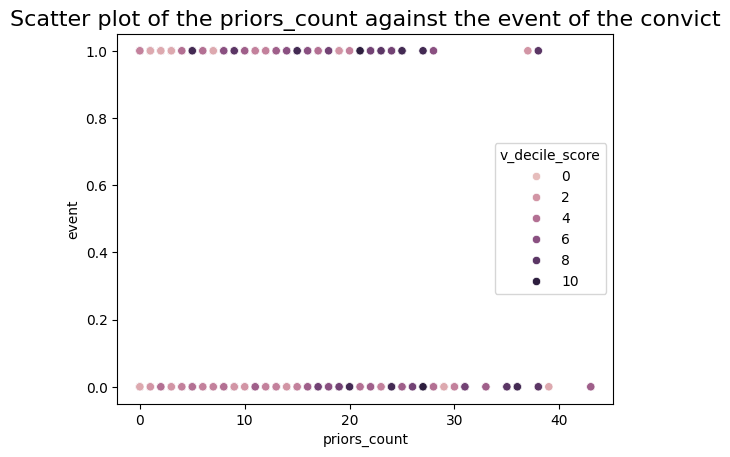

In [11]:
#compares priors_count and event of recidivism with respect to v_decile_score
sns.scatterplot(data=df,x='priors_count',y='event',hue = 'v_decile_score')
plt.title('Scatter plot of the priors_count against the event of the convict',fontsize = 16)
plt.show()

Regression plot

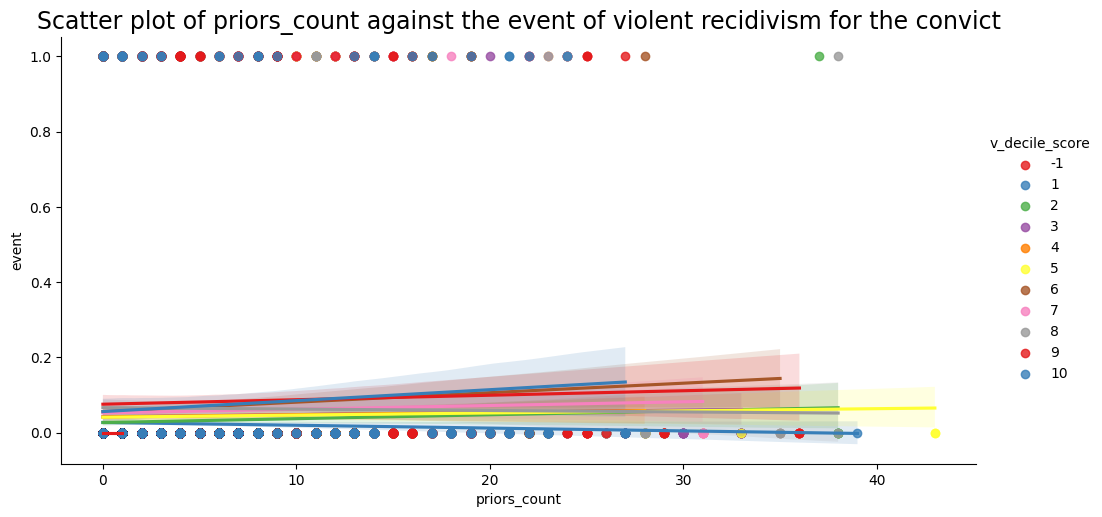

In [12]:
sns.lmplot(x='priors_count',y='event',hue = 'v_decile_score', data=df, palette="Set1", aspect=2)
plt.title('Scatter plot of priors_count against the event of violent recidivism for the convict', fontsize=17)
plt.show()

Kernel Density Plot

C:\Users\wissa\AppData\Local\Temp\ipykernel_7940\1381801858.py:1: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x="priors_count", y="event", hue="v_decile_score")


<Axes: xlabel='priors_count', ylabel='event'>

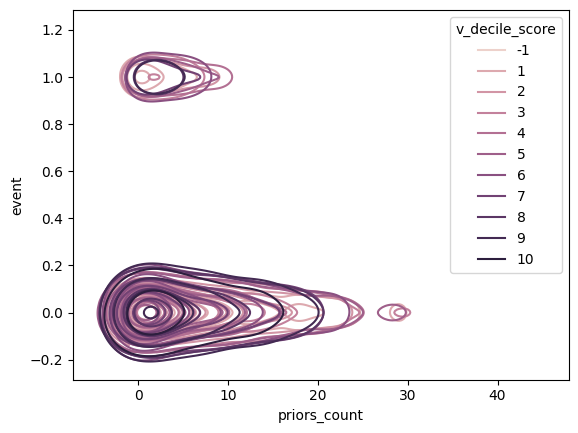

In [13]:
sns.kdeplot(data=df, x="priors_count", y="event", hue="v_decile_score")

Violin Plot

C:\Users\wissa\AppData\Local\Temp\ipykernel_7940\3305062784.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g1.set_xticklabels(g1.get_xticklabels(),rotation=45)


Text(0.5, 1.0, ' priors_count by event of violent recidivism conditioned on v_decile_score')

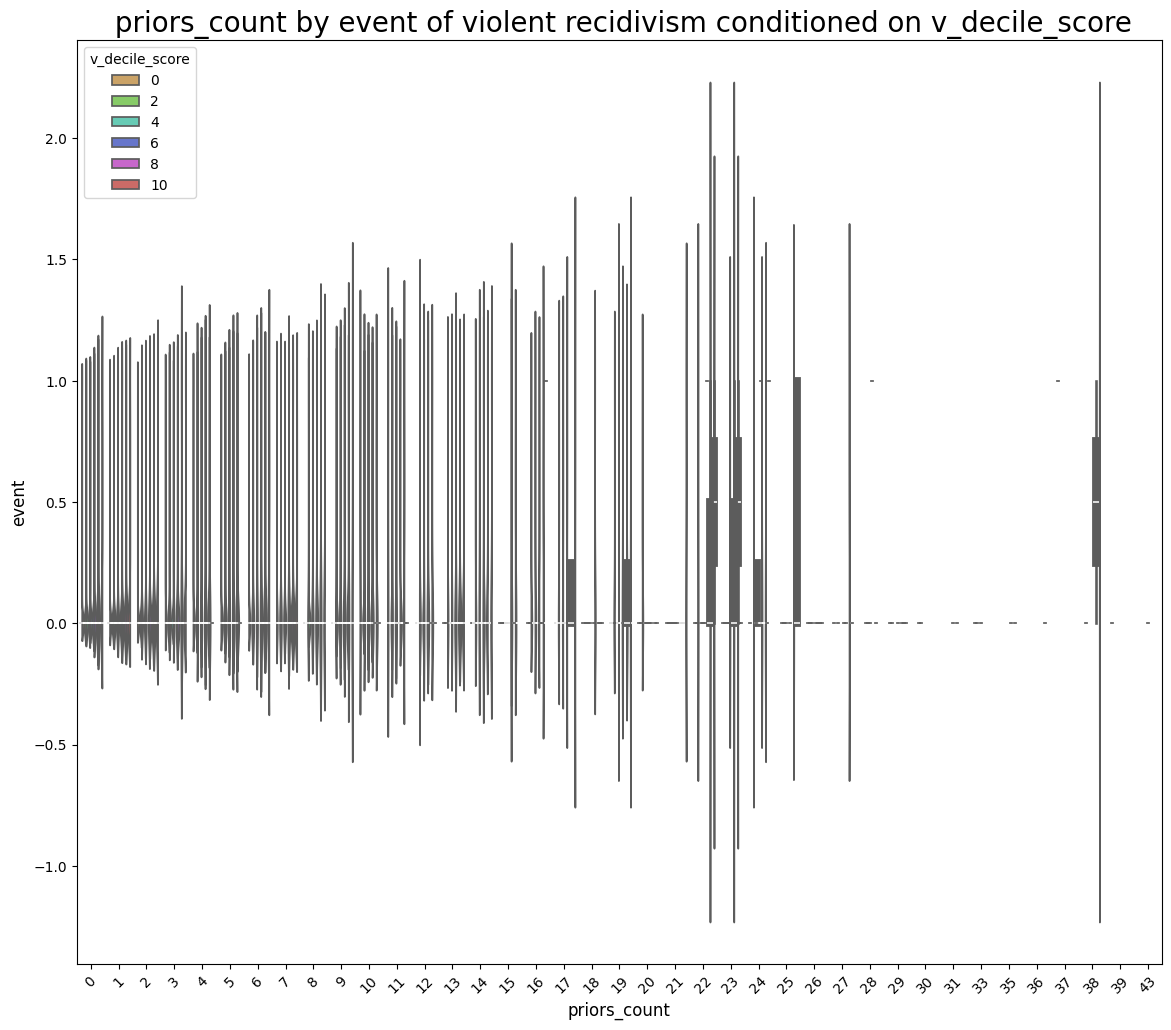

In [14]:
plt.figure(figsize = (14,12))
g1 = sns.violinplot(x="priors_count", y="event", data= df,
                    palette="hls", hue = "v_decile_score",split=True) # Note for now, the violin plot as parallel plots when the categorical values are greater than 2
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("priors_count", fontsize=12)
g1.set_ylabel("event", fontsize=12)
g1.set_title(" priors_count by event of violent recidivism conditioned on v_decile_score", fontsize=20)



---


### *age vs event of violent recidivism with respect to v_decile_score*


---

(Num vs Num)

Scatter plot

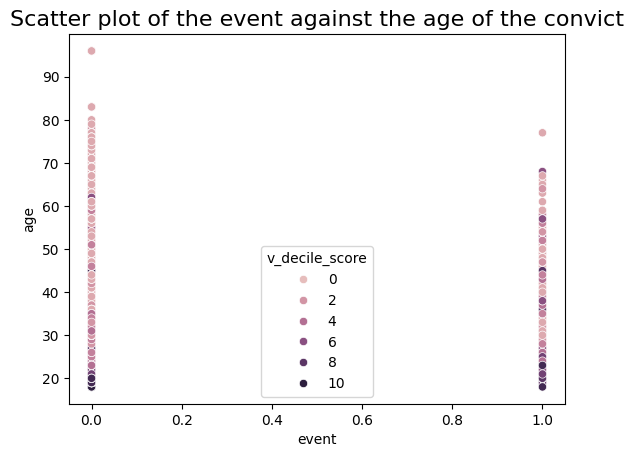

In [15]:
#compares age and event of violent recidivism with respect to decile_score
sns.scatterplot(data=df,x='event',y='age',hue = 'v_decile_score')
plt.title('Scatter plot of the event against the age of the convict',fontsize = 16)
plt.show()

Regression plot

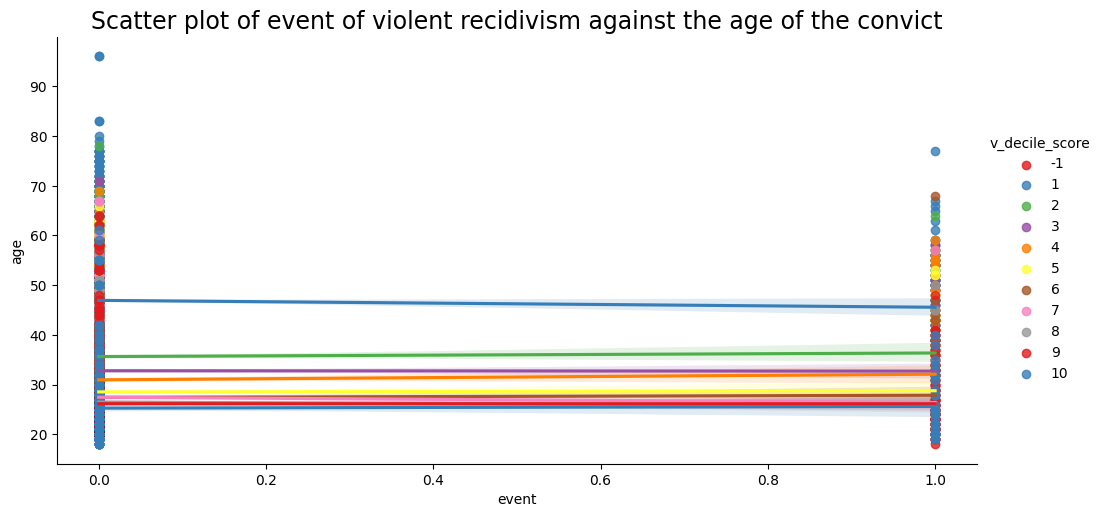

In [16]:
sns.lmplot(x='event',y='age',hue = 'v_decile_score', data=df, palette="Set1", aspect=2)
plt.title('Scatter plot of event of violent recidivism against the age of the convict', fontsize=17)
plt.show()

Kernel Density Plot

C:\Users\wissa\AppData\Local\Temp\ipykernel_7940\4184656974.py:1: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x="event", y="age", hue="v_decile_score")


<Axes: xlabel='event', ylabel='age'>

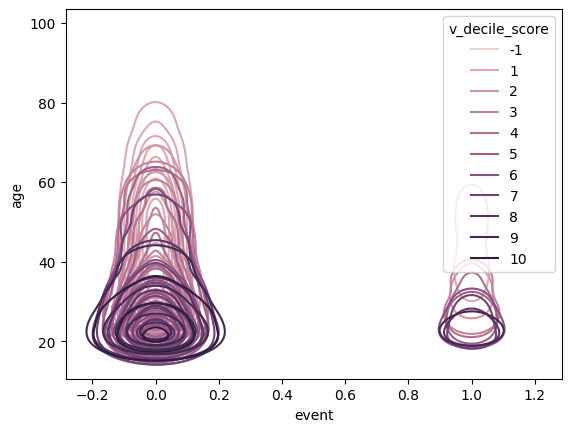

In [17]:
sns.kdeplot(data=df, x="event", y="age", hue="v_decile_score")

Violin Plot

C:\Users\wissa\AppData\Local\Temp\ipykernel_7940\3570818379.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g1.set_xticklabels(g1.get_xticklabels(),rotation=45)


Text(0.5, 1.0, ' event of violent recidivism by age conditioned on v_decile_score')

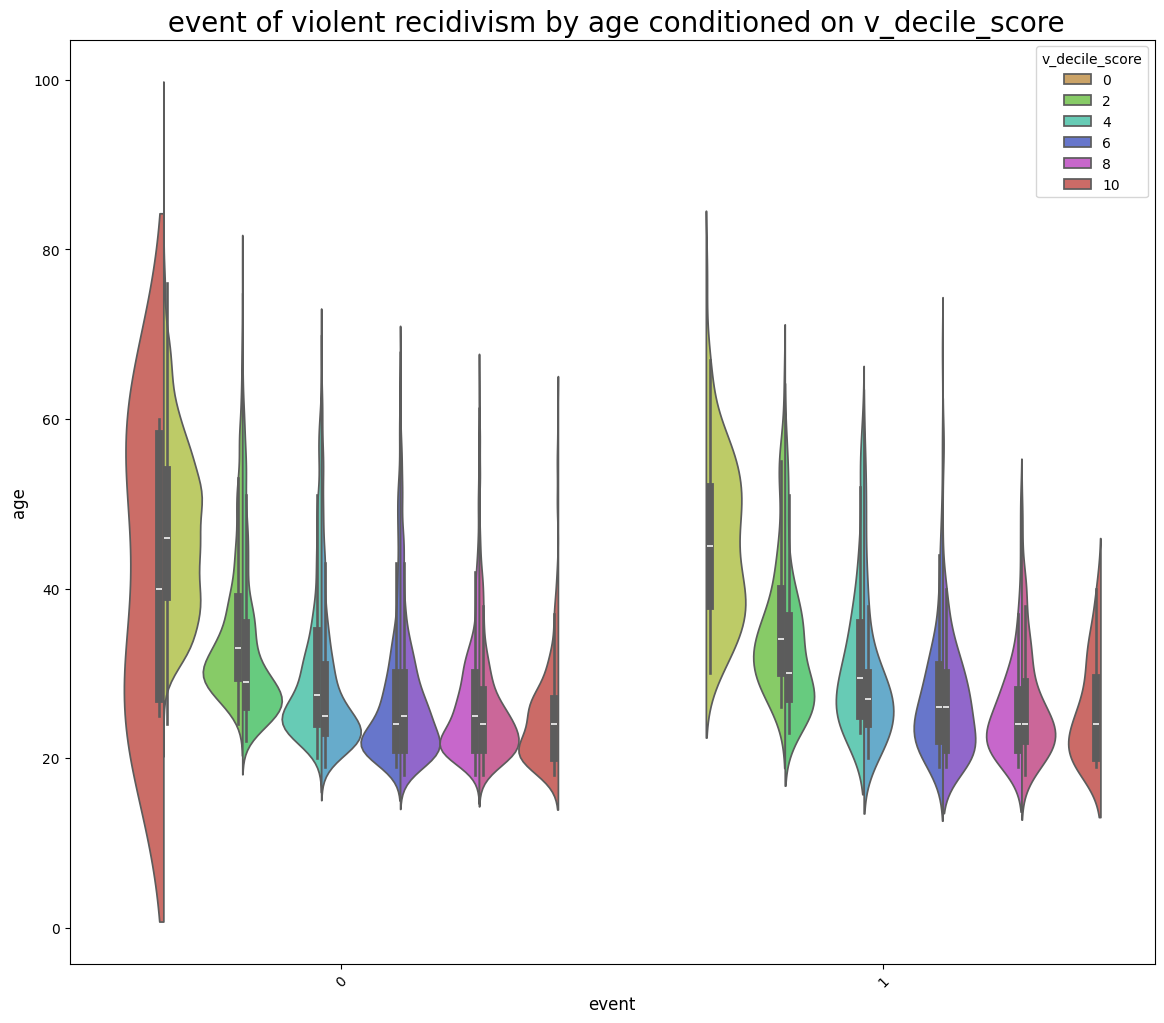

In [18]:
plt.figure(figsize = (14,12))
g1 = sns.violinplot(x="event", y="age", data= df,
                    palette="hls", hue = "v_decile_score",split=True) # Note for now, the violin plot as parallel plots when the categorical values are greater than 2
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("event", fontsize=12)
g1.set_ylabel("age", fontsize=12)
g1.set_title(" event of violent recidivism by age conditioned on v_decile_score", fontsize=20)



---


### *race vs v_decile_score with respect to event of violent recidivism*


---

(Num vs Cat)

Scatter plot

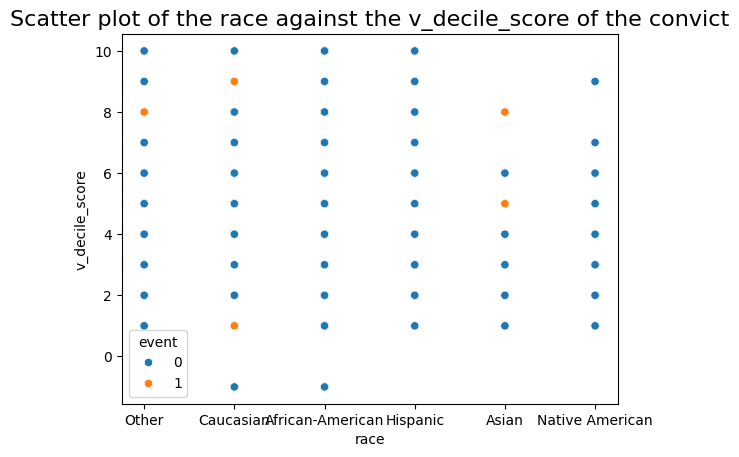

In [19]:
#compares race and decile_score with respect to event of violent recidivism
sns.scatterplot(data=df,x='race',y='v_decile_score',hue = 'event')
plt.title('Scatter plot of the race against the v_decile_score of the convict',fontsize = 16)
plt.show()

Violin Plot

C:\Users\wissa\AppData\Local\Temp\ipykernel_7940\321697399.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g1.set_xticklabels(g1.get_xticklabels(),rotation=45)


Text(0.5, 1.0, ' race by v_decile_score conditioned on event of violent recidivism')

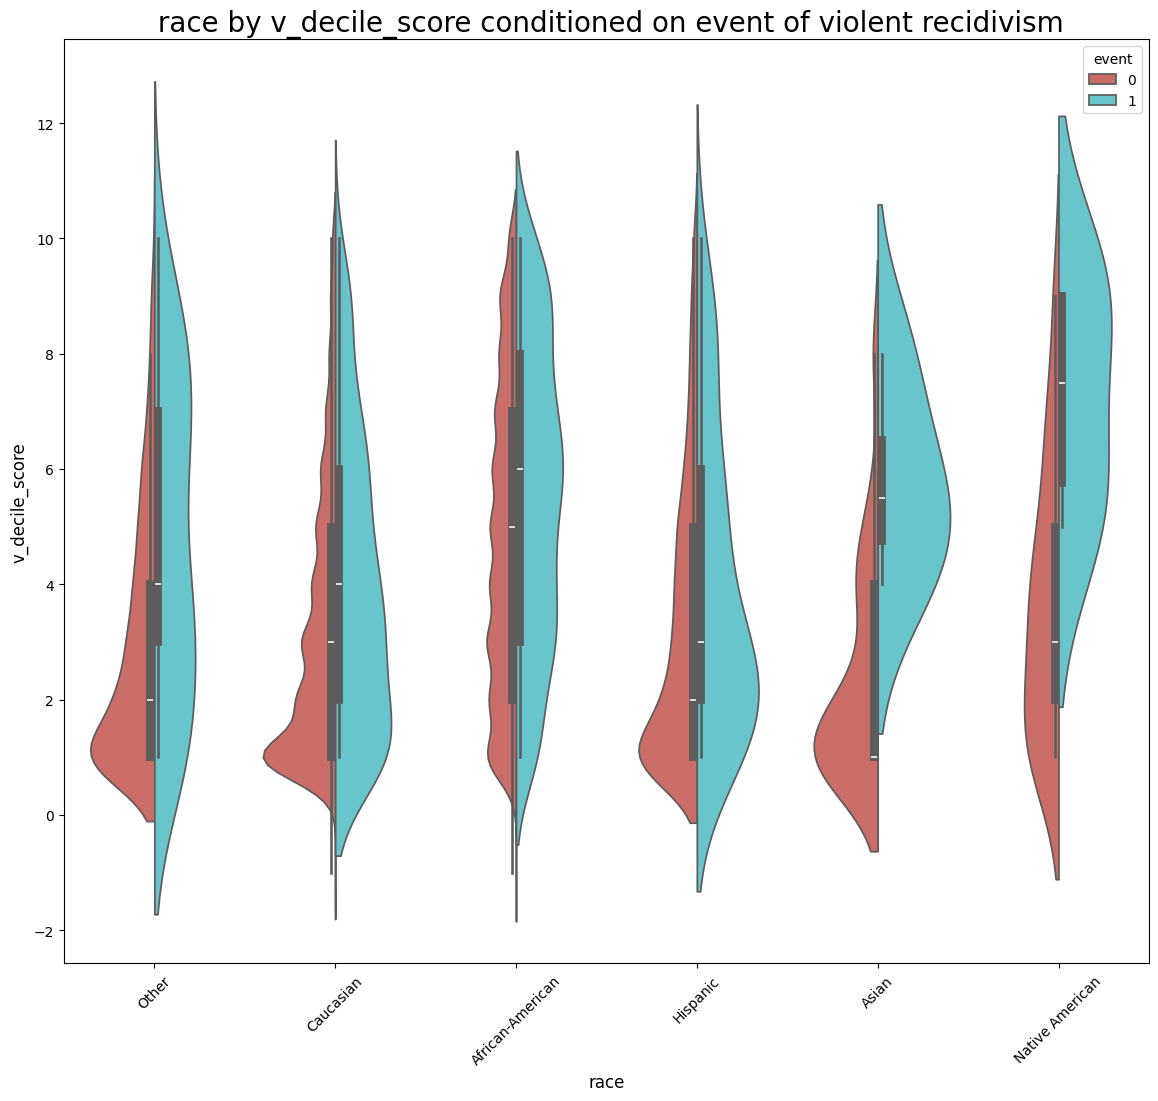

In [20]:
plt.figure(figsize = (14,12))
g1 = sns.violinplot(x="race", y="v_decile_score", data= df,
                    palette="hls", hue = "event",split=True) # Note for now, the violin plot as parallel plots when the categorical values are greater than 2
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("race", fontsize=12)
g1.set_ylabel("v_decile_score", fontsize=12)
g1.set_title(" race by v_decile_score conditioned on event of violent recidivism", fontsize=20)



---


### *c_charge_degree vs v_decile_score with respect to event of violent recidivism*


---

(Num vs Cat)

Scatter plot

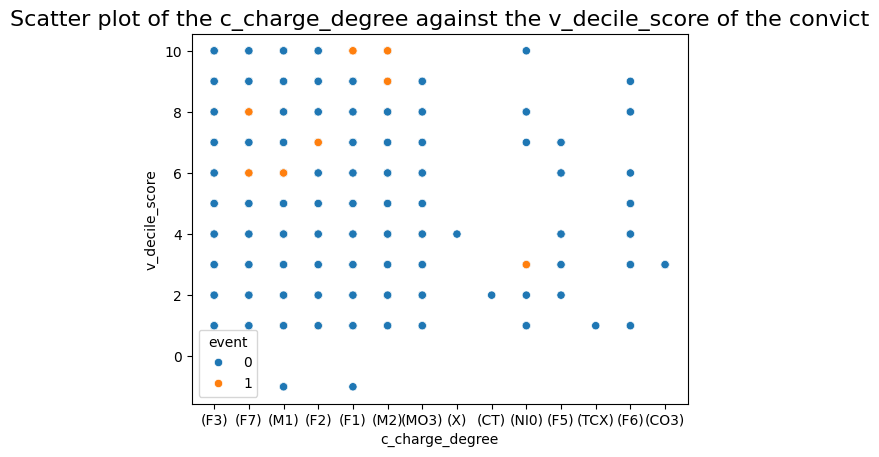

In [21]:
#compares c_charge_degree and v_decile_score with respect to event of violent recidivism
sns.scatterplot(data=df,x='c_charge_degree',y='v_decile_score',hue = 'event')
plt.title('Scatter plot of the c_charge_degree against the v_decile_score of the convict',fontsize = 16)
plt.show()

Violin Plot

C:\Users\wissa\AppData\Local\Temp\ipykernel_7940\395979089.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g1.set_xticklabels(g1.get_xticklabels(),rotation=45)


Text(0.5, 1.0, ' c_charge_degree by v_decile_score conditioned on event of violent recidivism')

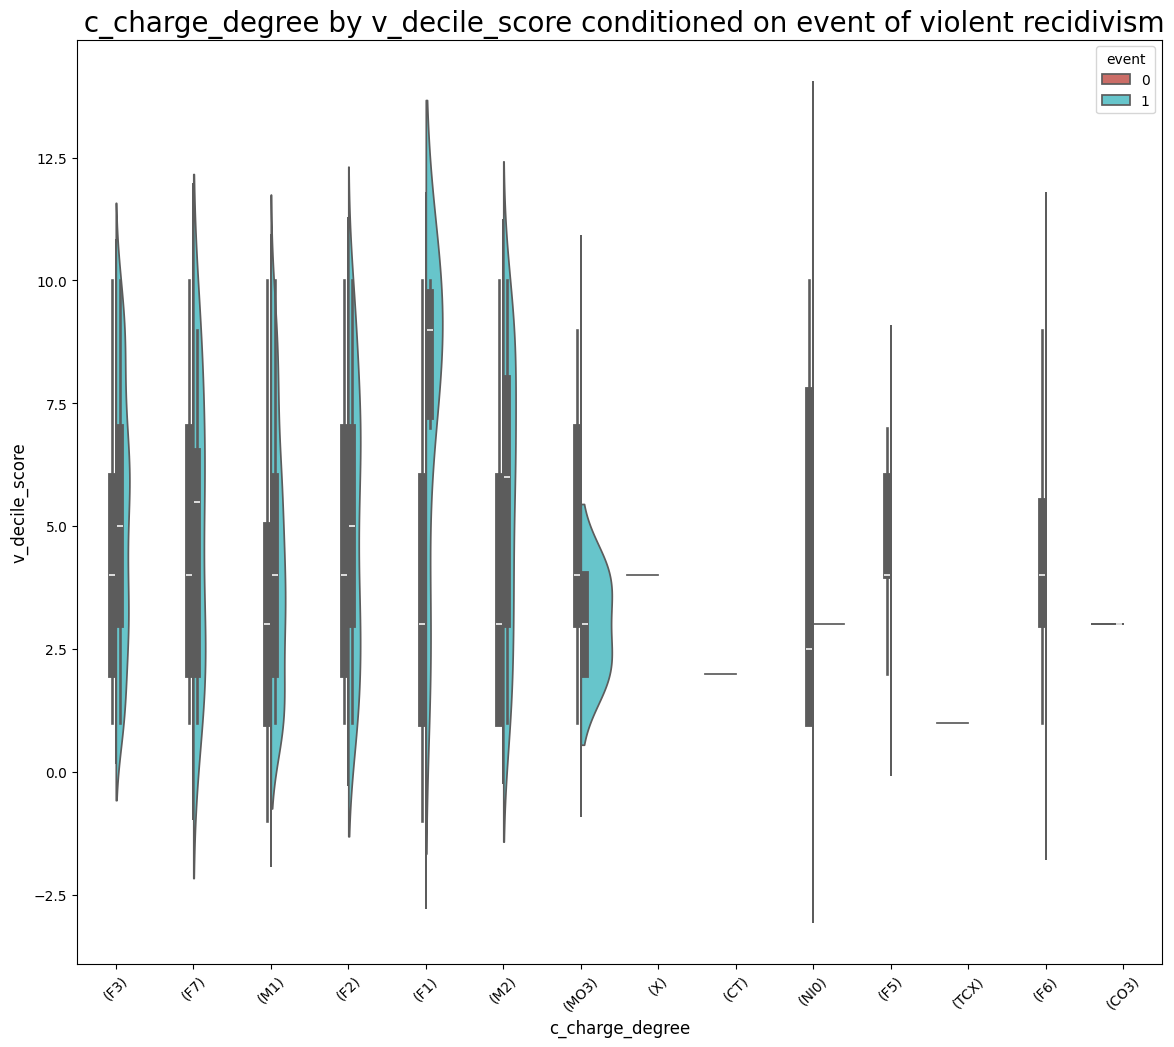

In [22]:
plt.figure(figsize = (14,12))
g1 = sns.violinplot(x="c_charge_degree", y="v_decile_score", data= df,
                    palette="hls", hue = "event",split=True) # Note for now, the violin plot as parallel plots when the categorical values are greater than 2
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("c_charge_degree", fontsize=12)
g1.set_ylabel("v_decile_score", fontsize=12)
g1.set_title(" c_charge_degree by v_decile_score conditioned on event of violent recidivism", fontsize=20)



---


### *r_charge_degree vs v_decile_score with respect to event of violent recidivism*


---
(Num vs Cat)


Scatter plot

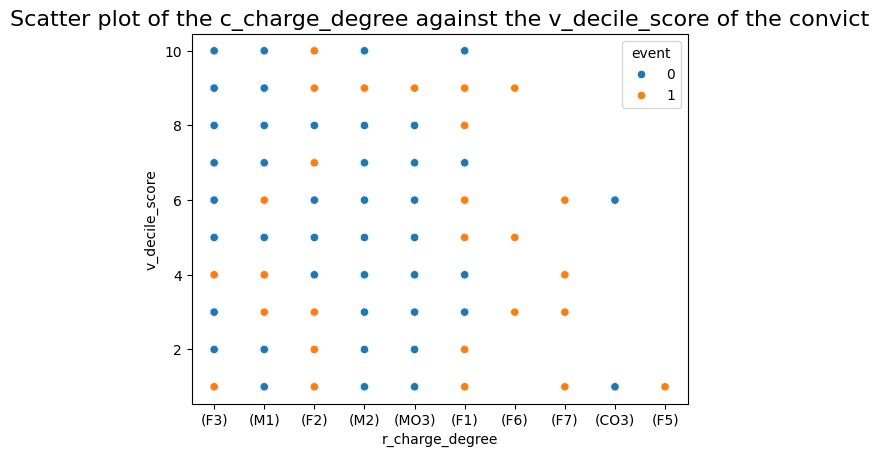

In [23]:
#compares r_charge_degree and v_decile_score with respect to event of violent recidivism
#looks at how "bad" their act of recidivism was compard to their predicticted
# violent recidivism likelyhood
sns.scatterplot(data=df,x='r_charge_degree',y='v_decile_score',hue = 'event')
plt.title('Scatter plot of the c_charge_degree against the v_decile_score of the convict',fontsize = 16)
plt.show()

Violin Plot

C:\Users\wissa\AppData\Local\Temp\ipykernel_7940\3567934328.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g1.set_xticklabels(g1.get_xticklabels(),rotation=45)


Text(0.5, 1.0, ' r_charge_degree by v_decile_score conditioned on event of violent recidivism')

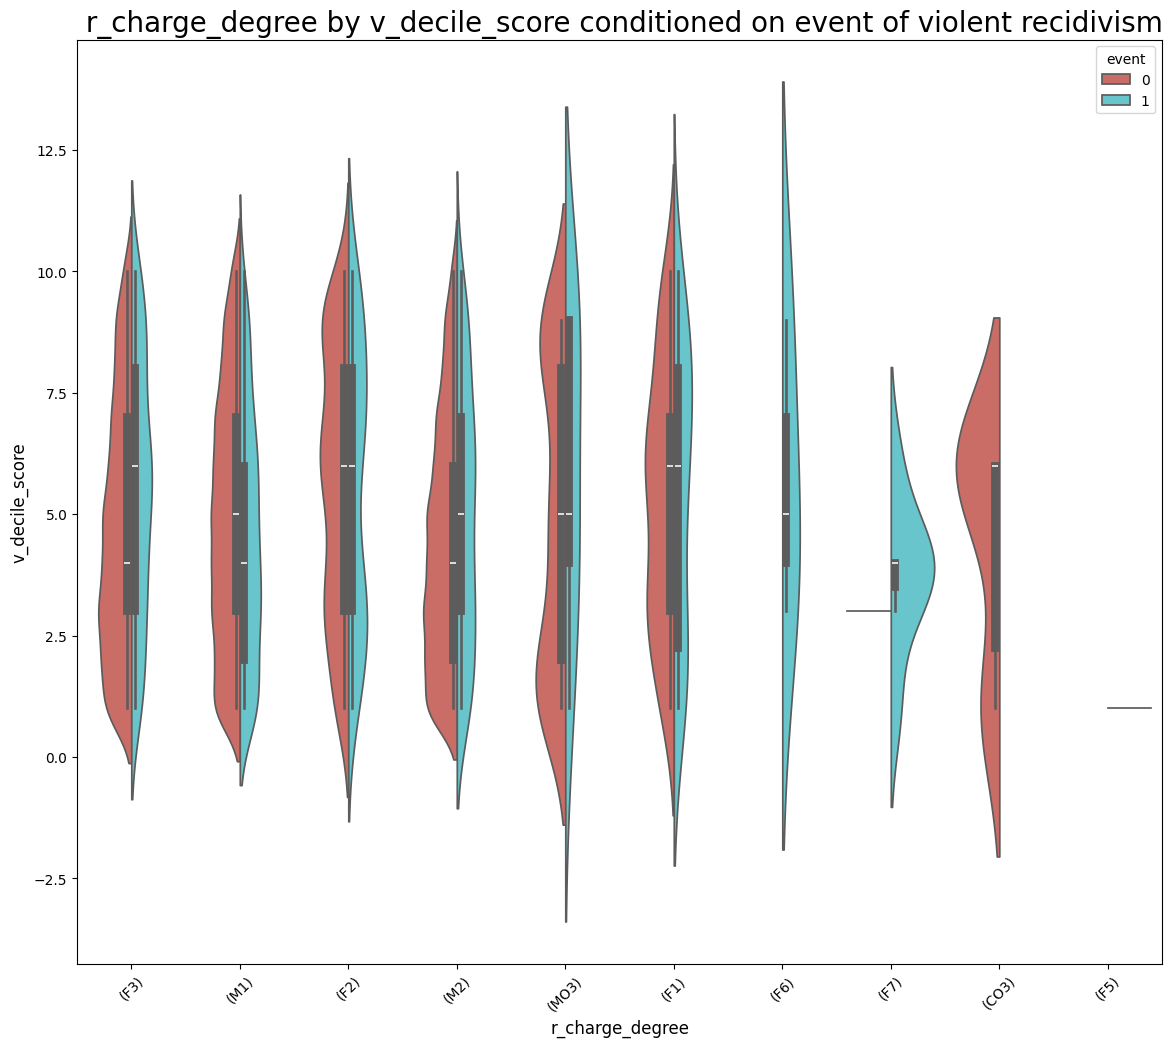

In [24]:
plt.figure(figsize = (14,12))
g1 = sns.violinplot(x="r_charge_degree", y="v_decile_score", data= df,
                    palette="hls", hue = "event",split=True) # Note for now, the violin plot as parallel plots when the categorical values are greater than 2
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("r_charge_degree", fontsize=12)
g1.set_ylabel("v_decile_score", fontsize=12)
g1.set_title(" r_charge_degree by v_decile_score conditioned on event of violent recidivism", fontsize=20)

### **Box Plots**
**Numerical vs (Numerical or Categorical) data**

(no Categorical vs Categorical data)

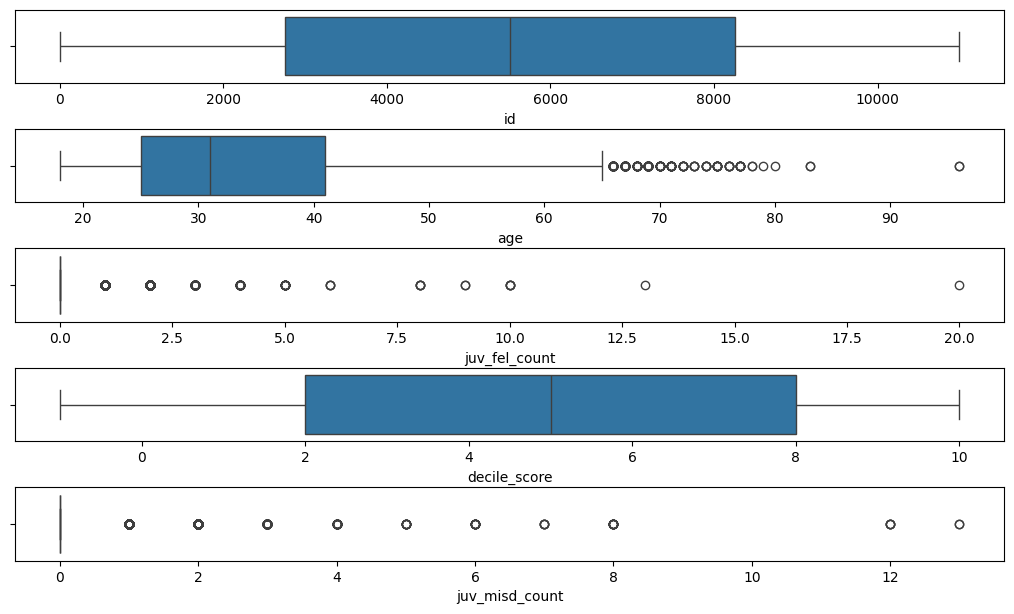

In [25]:
fig, ax = plt.subplots(5,figsize = (10,6))
# Select all numerical features in dataset
numerical_columns = df.select_dtypes(include='number').columns

for i in range(5):
    sns.boxplot(x=df[numerical_columns[i]],ax=ax[i])
fig.tight_layout(pad=0.2)

### **Class distribution**

This shows an overall view of how many people had certain v_decile_scores, and how many people in each score commited an event of violent recidivism.

<Axes: xlabel='v_decile_score', ylabel='count'>

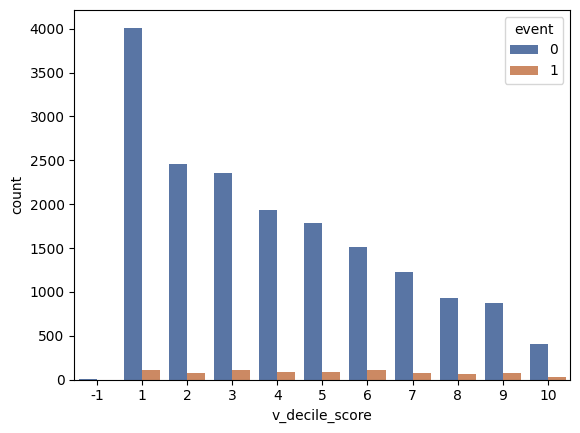

In [26]:
sns.countplot(x='v_decile_score', hue = 'event', data=df, palette='deep')

# Data Processing

In [27]:
%pip install dask[dataframe] -q
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

Note: you may need to restart the kernel to use updated packages.


# Step1. Processing cox-violent-parsed datasets




In [28]:
cvp_df = pd.read_csv('datasets/cox-violent-parsed_filt.csv')
cvpt_df = pd.read_csv('datasets/cox-violent-parsed_filt_transformed.csv') # Contains a column for income in place of sex column in cvp_df

## Adding the income column to cvp_df
cvp_df['income'] = cvpt_df['income'].values

In [29]:
print(cvp_df.shape)
cvp_df.head(10)

(18316, 41)


,id,name,first,last,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,violent_recid,is_violent_recid,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,priors_count.1,event,income
0,1.0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,1,0,0,0,-1.0,13/08/2013 6:03,14/08/2013 5:41,1.0,(F3),Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,0,0,Lower
1,2.0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,1,0,0,0,-1.0,13/08/2013 6:03,14/08/2013 5:41,1.0,(F3),Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,0,0,Lower
2,3.0,michael ryan,michael,ryan,Male,06/02/1985,31,25 - 45,Caucasian,0,5,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,Risk of Recidivism,5,Medium,31/12/2014,Risk of Violence,2,Low,0,0,Lower
3,4.0,kevon dixon,kevon,dixon,Male,22/01/1982,34,25 - 45,African-American,0,3,0,0,0,-1.0,26/01/2013 3:45,05/02/2013 5:36,1.0,(F3),Felony Battery w/Prior Convict,1,(F3),NaN,05/07/2013,Felony Battery (Dom Strang),NaN,NaN,1,(F3),05/07/2013,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,27/01/2013,Risk of Violence,1,Low,0,1,Lower
4,5.0,ed philo,ed,philo,Male,14/05/1991,24,Less than 25,African-American,0,4,0,1,4,-1.0,13/04/2013 4:58,14/04/2013 7:02,1.0,(F3),Possession of Cocaine,1,(M1),0.0,16/06/2013,Driving Under The Influence,16/06/2013,NaN,0,NaN,NaN,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,4,0,Lower
5,6.0,ed philo,ed,philo,Male,14/05/1991,24,Less than 25,African-American,0,4,0,1,4,-1.0,13/04/2013 4:58,14/04/2013 7:02,1.0,(F3),Possession of Cocaine,1,(M1),0.0,16/06/2013,Driving Under The Influence,16/06/2013,NaN,0,NaN,NaN,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,4,0,Lower
6,7.0,ed philo,ed,philo,Male,14/05/1991,24,Less than 25,African-American,0,4,0,1,4,-1.0,13/04/2013 4:58,14/04/2013 7:02,1.0,(F3),Possession of Cocaine,1,(M1),0.0,16/06/2013,Driving Under The Influence,16/06/2013,NaN,0,NaN,NaN,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,4,0,Lower
7,8.0,ed philo,ed,philo,Male,14/05/1991,24,Less than 25,African-American,0,4,0,1,4,-1.0,13/04/2013 4:58,14/04/2013 7:02,1.0,(F3),Possession of Cocaine,1,(M1),0.0,16/06/2013,Driving Under The Influence,16/06/2013,NaN,0,NaN,NaN,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,4,0,Lower
8,9.0,ed philo,ed,philo,Male,14/05/1991,24,Less than 25,African-American,0,4,0,1,4,-1.0,13/04/2013 4:58,14/04/2013 7:02,1.0,(F3),Possession of Cocaine,1,(M1),0.0,16/06/2013,Driving Under The Influence,16/06/2013,NaN,0,NaN,NaN,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,4,0,Lower
9,10.0,marcu brown,marcu,brown,Male,21/01/1993,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,1.0,(F3),Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,Risk of Recidivism,8,High,13/01/2013,Risk of Violence,6,Medium,1,0,Lower


In [30]:
cvp_df.drop('id', axis=1, inplace=True)
cvp_df = cvp_df.drop_duplicates()
print(cvp_df.shape)
cvp_df.head(10)

(11300, 40)


,name,first,last,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,violent_recid,is_violent_recid,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,priors_count.1,event,income
0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,1,0,0,0,-1.0,13/08/2013 6:03,14/08/2013 5:41,1.0,(F3),Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,0,0,Lower
2,michael ryan,michael,ryan,Male,06/02/1985,31,25 - 45,Caucasian,0,5,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,Risk of Recidivism,5,Medium,31/12/2014,Risk of Violence,2,Low,0,0,Lower
3,kevon dixon,kevon,dixon,Male,22/01/1982,34,25 - 45,African-American,0,3,0,0,0,-1.0,26/01/2013 3:45,05/02/2013 5:36,1.0,(F3),Felony Battery w/Prior Convict,1,(F3),NaN,05/07/2013,Felony Battery (Dom Strang),NaN,NaN,1,(F3),05/07/2013,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,27/01/2013,Risk of Violence,1,Low,0,1,Lower
4,ed philo,ed,philo,Male,14/05/1991,24,Less than 25,African-American,0,4,0,1,4,-1.0,13/04/2013 4:58,14/04/2013 7:02,1.0,(F3),Possession of Cocaine,1,(M1),0.0,16/06/2013,Driving Under The Influence,16/06/2013,NaN,0,NaN,NaN,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,4,0,Lower
9,marcu brown,marcu,brown,Male,21/01/1993,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,1.0,(F3),Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,Risk of Recidivism,8,High,13/01/2013,Risk of Violence,6,Medium,1,0,Lower
10,bouthy pierrelouis,bouthy,pierrelouis,Male,22/01/1973,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,76.0,(F7),arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,Risk of Recidivism,1,Low,26/03/2013,Risk of Violence,1,Low,2,0,Lower
11,marsha miles,marsha,miles,Male,22/08/1971,44,25 - 45,Other,0,1,0,0,0,0.0,30/11/2013 4:50,01/12/2013 12:28,0.0,(M1),Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,Risk of Recidivism,1,Low,30/11/2013,Risk of Violence,1,Low,0,0,Lower
12,edward riddle,edward,riddle,Male,23/07/1974,41,25 - 45,Caucasian,0,6,0,0,14,-1.0,18/02/2014 5:08,24/02/2014 12:18,1.0,(F3),Possession Burglary Tools,1,(F2),0.0,31/03/2014,Poss of Firearm by Convic Felo,31/03/2014,NaN,0,NaN,NaN,NaN,Risk of Recidivism,6,Medium,19/02/2014,Risk of Violence,2,Low,14,0,Lower
14,steven stewart,steven,stewart,Male,25/02/1973,43,25 - 45,Other,0,4,0,0,3,-1.0,29/08/2013 8:55,30/08/2013 8:42,1.0,(F3),arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,Risk of Recidivism,4,Low,30/08/2013,Risk of Violence,3,Low,3,0,Lower
17,elizabeth thieme,elizabeth,thieme,Female,03/06/1976,39,25 - 45,Caucasian,0,1,0,0,0,-1.0,15/03/2014 5:35,18/03/2014 4:28,1.0,(M1),Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,Risk of Recidivism,1,Low,16/03/2014,Risk of Violence,1,Low,0,0,Higher


## Dropping unuseful features

In [31]:
## Dropping unuseful and repetitive columns, but keeping first(name), last(name), and dob for joining the datasets later
cvp_df.drop(['name','age_cat','c_days_from_compas','violent_recid','type_of_assessment','v_type_of_assessment',
             'c_charge_desc', 'r_charge_desc', 'vr_charge_desc', 'decile_score.1', 'priors_count.1',], axis=1, inplace=True)

## Dropping 'race' column. Use the next line instead to keep the race in another version for a comparison.
cvp_df.drop('race', axis=1, inplace=True)
# cvp_df = pd.get_dummies(cvp_df, columns=['race'], drop_first=True)

## Replacing jail in/out with jail duration
cvp_df['c_jail_in'] = pd.to_datetime(cvp_df['c_jail_in'], dayfirst=True)
cvp_df['c_jail_out'] = pd.to_datetime(cvp_df['c_jail_out'], dayfirst=True)
cvp_df['jail_duration'] = (cvp_df['c_jail_out'] - cvp_df['c_jail_in']).dt.days
cvp_df.drop(['c_jail_in', 'c_jail_out'], axis=1, inplace=True)

In [32]:
print(cvp_df.shape)
cvp_df.head(10)

(11300, 27)


,first,last,sex,dob,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_charge_degree,is_recid,r_charge_degree,r_days_from_arrest,r_offense_date,r_jail_in,is_violent_recid,vr_charge_degree,vr_offense_date,score_text,screening_date,v_decile_score,v_score_text,event,income,jail_duration
0,miguel,hernandez,Male,18/04/1947,69,0,1,0,0,0,-1.0,(F3),0,NaN,NaN,NaN,NaN,0,NaN,NaN,Low,14/08/2013,1,Low,0,Lower,0.0
2,michael,ryan,Male,06/02/1985,31,0,5,0,0,0,NaN,NaN,-1,NaN,NaN,NaN,NaN,0,NaN,NaN,Medium,31/12/2014,2,Low,0,Lower,NaN
3,kevon,dixon,Male,22/01/1982,34,0,3,0,0,0,-1.0,(F3),1,(F3),NaN,05/07/2013,NaN,1,(F3),05/07/2013,Low,27/01/2013,1,Low,1,Lower,10.0
4,ed,philo,Male,14/05/1991,24,0,4,0,1,4,-1.0,(F3),1,(M1),0.0,16/06/2013,16/06/2013,0,NaN,NaN,Low,14/04/2013,3,Low,0,Lower,1.0
9,marcu,brown,Male,21/01/1993,23,0,8,1,0,1,NaN,(F3),0,NaN,NaN,NaN,NaN,0,NaN,NaN,High,13/01/2013,6,Medium,0,Lower,NaN
10,bouthy,pierrelouis,Male,22/01/1973,43,0,1,0,0,2,NaN,(F7),0,NaN,NaN,NaN,NaN,0,NaN,NaN,Low,26/03/2013,1,Low,0,Lower,NaN
11,marsha,miles,Male,22/08/1971,44,0,1,0,0,0,0.0,(M1),0,NaN,NaN,NaN,NaN,0,NaN,NaN,Low,30/11/2013,1,Low,0,Lower,1.0
12,edward,riddle,Male,23/07/1974,41,0,6,0,0,14,-1.0,(F3),1,(F2),0.0,31/03/2014,31/03/2014,0,NaN,NaN,Medium,19/02/2014,2,Low,0,Lower,6.0
14,steven,stewart,Male,25/02/1973,43,0,4,0,0,3,-1.0,(F3),0,NaN,NaN,NaN,NaN,0,NaN,NaN,Low,30/08/2013,3,Low,0,Lower,0.0
17,elizabeth,thieme,Female,03/06/1976,39,0,1,0,0,0,-1.0,(M1),0,NaN,NaN,NaN,NaN,0,NaN,NaN,Low,16/03/2014,1,Low,0,Higher,2.0


### Converting categorical scale variables to nummerical values

In [33]:
## Assigning numerical values to represent the intensity of different charge degrees.
charge_degree_mapping = {'(M1)': 1, '(M2)': 2, '(MO3)': 3, '(F1)': 6, '(F2)': 8, '(F3)': 10, '(F5)': 12, '(F6)': 14, '(F7)': 16}
cvp_df['c_charge_degree'] = cvp_df['c_charge_degree'].map(charge_degree_mapping)
cvp_df['r_charge_degree'] = cvp_df['r_charge_degree'].map(charge_degree_mapping)
cvp_df['vr_charge_degree'] = cvp_df['vr_charge_degree'].map(charge_degree_mapping)

### Converting to correct formats and some cleaning

In [34]:
## Converting date columns to datetime format
cvp_df['dob'] = pd.to_datetime(cvp_df['dob'], dayfirst=True)
cvp_df['r_offense_date'] = pd.to_datetime(cvp_df['r_offense_date'], dayfirst=True)
cvp_df['r_jail_in'] = pd.to_datetime(cvp_df['r_jail_in'], dayfirst=True)
cvp_df['vr_offense_date'] = pd.to_datetime(cvp_df['vr_offense_date'], dayfirst=True)
cvp_df['screening_date'] = pd.to_datetime(cvp_df['screening_date'], dayfirst=True)

## Replacing -1s with nan in event and is_recid
cvp_df['event'] = cvp_df['event'].replace(-1, np.nan)
cvp_df['is_recid'] = cvp_df['is_recid'].replace(-1, np.nan)

cvp_df['first'] = cvp_df['first'].str.lower()
cvp_df['last'] = cvp_df['last'].str.lower()

In [35]:
cvp_df.head(8)

,first,last,sex,dob,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_charge_degree,is_recid,r_charge_degree,r_days_from_arrest,r_offense_date,r_jail_in,is_violent_recid,vr_charge_degree,vr_offense_date,score_text,screening_date,v_decile_score,v_score_text,event,income,jail_duration
0,miguel,hernandez,Male,1947-04-18,69,0,1,0,0,0,-1.0,10.0,0.0,NaN,NaN,NaT,NaT,0,NaN,NaT,Low,2013-08-14,1,Low,0,Lower,0.0
2,michael,ryan,Male,1985-02-06,31,0,5,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,0,NaN,NaT,Medium,2014-12-31,2,Low,0,Lower,NaN
3,kevon,dixon,Male,1982-01-22,34,0,3,0,0,0,-1.0,10.0,1.0,10.0,NaN,2013-07-05,NaT,1,10.0,2013-07-05,Low,2013-01-27,1,Low,1,Lower,10.0
4,ed,philo,Male,1991-05-14,24,0,4,0,1,4,-1.0,10.0,1.0,1.0,0.0,2013-06-16,2013-06-16,0,NaN,NaT,Low,2013-04-14,3,Low,0,Lower,1.0
9,marcu,brown,Male,1993-01-21,23,0,8,1,0,1,NaN,10.0,0.0,NaN,NaN,NaT,NaT,0,NaN,NaT,High,2013-01-13,6,Medium,0,Lower,NaN
10,bouthy,pierrelouis,Male,1973-01-22,43,0,1,0,0,2,NaN,16.0,0.0,NaN,NaN,NaT,NaT,0,NaN,NaT,Low,2013-03-26,1,Low,0,Lower,NaN
11,marsha,miles,Male,1971-08-22,44,0,1,0,0,0,0.0,1.0,0.0,NaN,NaN,NaT,NaT,0,NaN,NaT,Low,2013-11-30,1,Low,0,Lower,1.0
12,edward,riddle,Male,1974-07-23,41,0,6,0,0,14,-1.0,10.0,1.0,8.0,0.0,2014-03-31,2014-03-31,0,NaN,NaT,Medium,2014-02-19,2,Low,0,Lower,6.0


# Step2. Processing compas-scores-raw dataset

In [36]:
## This database contains additional useful variables for predicting decile scores
csr_df = pd.read_csv('datasets/compas-scores-raw.csv')
csr_df.head()

,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,ScaleSet,AssessmentReason,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0


In [37]:
## Extracting different risk scores as independent columns
csr_df['RiskOfViolence_RawScore'] = csr_df.apply(lambda row: row.RawScore if row.Scale_ID == 7 else np.nan, axis=1)
csr_df['RiskOfViolence_DecileScore'] = csr_df.apply(lambda row: row.DecileScore if row.Scale_ID == 7 else np.nan, axis=1)
csr_df['RiskOfViolence_ScoreText'] = csr_df.apply(lambda row: row.ScoreText if row.Scale_ID == 7 else np.nan, axis=1)

csr_df['RiskOfRecidivism_RawScore'] = csr_df.apply(lambda row: row.RawScore if row.Scale_ID == 8 else np.nan, axis=1)
csr_df['RiskOfRecidivism_DecileScore'] = csr_df.apply(lambda row: row.DecileScore if row.Scale_ID == 8 else np.nan, axis=1)
csr_df['RiskOfRecidivism_ScoreText'] = csr_df.apply(lambda row: row.ScoreText if row.Scale_ID == 8 else np.nan, axis=1)

csr_df['RiskOfFailureToAppear_RawScore'] = csr_df.apply(lambda row: row.RawScore if row.Scale_ID == 18 else np.nan, axis=1)
csr_df['RiskOfFailureToAppear_DecileScore'] = csr_df.apply(lambda row: row.DecileScore if row.Scale_ID == 18 else np.nan, axis=1)
csr_df['RiskOfFailureToAppear_ScoreText'] = csr_df.apply(lambda row: row.ScoreText if row.Scale_ID == 18 else np.nan, axis=1)

In [38]:
csr_df.head(8)

,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,ScaleSet,AssessmentReason,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted,RiskOfViolence_RawScore,RiskOfViolence_DecileScore,RiskOfViolence_ScoreText,RiskOfRecidivism_RawScore,RiskOfRecidivism_DecileScore,RiskOfRecidivism_ScoreText,RiskOfFailureToAppear_RawScore,RiskOfFailureToAppear_DecileScore,RiskOfFailureToAppear_ScoreText
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0,-2.08,4.0,Low,NaN,NaN,NaN,NaN,NaN,NaN
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0,NaN,NaN,NaN,-1.06,2.0,Low,NaN,NaN,NaN
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0,NaN,NaN,NaN,NaN,NaN,NaN,15.0,1.0,Low
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0,-2.84,2.0,Low,NaN,NaN,NaN,NaN,NaN,NaN
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0,NaN,NaN,NaN,-1.50,1.0,Low,NaN,NaN,NaN
5,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,18,Risk of Failure to Appear,19.00,3,Low,New,1,0,NaN,NaN,NaN,NaN,NaN,NaN,19.0,3.0,Low
6,50855,57181,51963,PRETRIAL,DAYES,DANIEL,NaN,Male,African-American,08/25/94,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,4,High,7,Risk of Violence,-1.20,8,High,New,1,0,-1.20,8.0,High,NaN,NaN,NaN,NaN,NaN,NaN
7,50855,57181,51963,PRETRIAL,DAYES,DANIEL,NaN,Male,African-American,08/25/94,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,4,High,8,Risk of Recidivism,0.18,8,High,New,1,0,NaN,NaN,NaN,0.18,8.0,High,NaN,NaN,NaN


In [39]:
## Merging duplicate rows
repeated_columns = ['Person_ID','Agency_Text','LastName','FirstName','DateOfBirth','LegalStatus',
                    'CustodyStatus','MaritalStatus','RecSupervisionLevel','RecSupervisionLevelText']

risk_columns = ['RiskOfViolence_RawScore','RiskOfViolence_DecileScore','RiskOfViolence_ScoreText',
                'RiskOfRecidivism_RawScore','RiskOfRecidivism_DecileScore','RiskOfRecidivism_ScoreText',
                'RiskOfFailureToAppear_RawScore','RiskOfFailureToAppear_DecileScore','RiskOfFailureToAppear_ScoreText']

agg_dict = {col: 'first' for col in risk_columns}
csr_df = csr_df.groupby(repeated_columns).agg(agg_dict).reset_index()

In [40]:
csr_df['DateOfBirth'] = pd.to_datetime(csr_df['DateOfBirth'], format='%m/%d/%y')
csr_df['LastName'] = csr_df['LastName'].str.lower()
csr_df['FirstName'] = csr_df['FirstName'].str.lower()

csr_df.drop('Person_ID', axis=1, inplace=True)

In [41]:
csr_df[csr_df['LastName'] == 'philo']

,Agency_Text,LastName,FirstName,DateOfBirth,LegalStatus,CustodyStatus,MaritalStatus,RecSupervisionLevel,RecSupervisionLevelText,RiskOfViolence_RawScore,RiskOfViolence_DecileScore,RiskOfViolence_ScoreText,RiskOfRecidivism_RawScore,RiskOfRecidivism_DecileScore,RiskOfRecidivism_ScoreText,RiskOfFailureToAppear_RawScore,RiskOfFailureToAppear_DecileScore,RiskOfFailureToAppear_ScoreText
2379,PRETRIAL,philo,ed,1991-05-14,Pretrial,Jail Inmate,Single,1,Low,-2.26,3.0,Low,-0.66,4.0,Low,26.0,7.0,Medium
11595,Probation,philo,ed,1991-05-14,Conditional Release,Probation,Single,3,Medium with Override Consideration,-1.31,7.0,Medium,0.44,9.0,High,25.0,5.0,Medium
11596,Probation,philo,ed,1991-05-14,Post Sentence,Probation,Single,3,Medium with Override Consideration,-1.27,7.0,Medium,0.49,9.0,High,28.0,8.0,High


# Step3. Combining cvp_df with csr_df

In [42]:
## final data frame (fdf)
fdf = pd.merge(cvp_df, csr_df, left_on=['first', 'last', 'dob'], right_on=['FirstName', 'LastName', 'DateOfBirth'], how='inner')
fdf.drop(['first', 'last', 'dob'], axis=1, inplace=True)

In [43]:
print(fdf.shape)
print(fdf[['LastName', 'FirstName', 'DateOfBirth']].drop_duplicates().shape[0])

(9543, 42)
8489


# Step4: Imputing missing values for mixed-type data

In [44]:
# Check missing values:

print(fdf.isnull().sum())


sex                                     0
age                                     0
juv_fel_count                           0
decile_score                            0
juv_misd_count                          0
juv_other_count                         0
priors_count                            0
days_b_screening_arrest               826
c_charge_degree                       532
is_recid                              507
r_charge_degree                      5911
r_days_from_arrest                   7041
r_offense_date                       5909
r_jail_in                            7041
is_violent_recid                        0
vr_charge_degree                     8400
vr_offense_date                      8400
score_text                              7
screening_date                          0
v_decile_score                          0
v_score_text                            1
event                                   0
income                                  0
jail_duration                     

### Imputing numerical columns

In [45]:
# To impute numerical columns we use Mean/Median Imputation
# Identify numeric columns (excluding categorical)
numeric_cols = fdf.select_dtypes(include=['number']).columns

# Initialize the imputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')  # Use 'mean' if preferred

# Apply imputation
fdf[numeric_cols] = imputer.fit_transform(fdf[numeric_cols])

In [46]:
# Check missing values after imputing the numerical columns:

print(fdf.isnull().sum())

sex                                     0
age                                     0
juv_fel_count                           0
decile_score                            0
juv_misd_count                          0
juv_other_count                         0
priors_count                            0
days_b_screening_arrest                 0
c_charge_degree                         0
is_recid                                0
r_charge_degree                         0
r_days_from_arrest                      0
r_offense_date                       5909
r_jail_in                            7041
is_violent_recid                        0
vr_charge_degree                        0
vr_offense_date                      8400
score_text                              7
screening_date                          0
v_decile_score                          0
v_score_text                            1
event                                   0
income                                  0
jail_duration                     

### Imputing categorical values

In [47]:
# Risk score we have (Low, Medium, High)
# Violent risk score (Low, Medium, High)
mode_cols = ["score_text","v_score_text", "RiskOfViolence_ScoreText","RiskOfRecidivism_ScoreText"]
for col in mode_cols:
    fdf[col].fillna(fdf[col].mode()[0], inplace=True)

# Date of prior offense, date of prior jail entry, and date of violent offense
    unknown_cols = [ "r_offense_date","r_jail_in","vr_offense_date"]

for col in unknown_cols:
    fdf[col].fillna("Unknown", inplace=True)

C:\Users\wissa\AppData\Local\Temp\ipykernel_7940\263880281.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fdf[col].fillna(fdf[col].mode()[0], inplace=True)
C:\Users\wissa\AppData\Local\Temp\ipykernel_7940\263880281.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

In [48]:
# check if there are any categorical missing values
print(fdf.isnull().sum())


sex                                  0
age                                  0
juv_fel_count                        0
decile_score                         0
juv_misd_count                       0
juv_other_count                      0
priors_count                         0
days_b_screening_arrest              0
c_charge_degree                      0
is_recid                             0
r_charge_degree                      0
r_days_from_arrest                   0
r_offense_date                       0
r_jail_in                            0
is_violent_recid                     0
vr_charge_degree                     0
vr_offense_date                      0
score_text                           0
screening_date                       0
v_decile_score                       0
v_score_text                         0
event                                0
income                               0
jail_duration                        0
Agency_Text                          0
LastName                 

## Download section

In [49]:
## Save the modified dataset
csv_filename = "datasets/final-preprocessed-imputed-compas-df.csv"
fdf.to_csv(csv_filename, index=False)

In [50]:
## Downloading the file
try:
    from google.colab import files
    files.download(csv_filename)
except ImportError:
    print(f"Download manually from your working directory: {csv_filename}")

Download manually from your working directory: datasets/final-preprocessed-imputed-compas-df.csv
